In [1]:
import os
import numpy as np
import pandas as pd
from ExKMC.Tree import Tree as ExTree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *

from sklearn.metrics import adjusted_rand_score, accuracy_score

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

### Load Data

In [ ]:
# Read and process data:
data, data_label_array, feature_labels, scaler = load_preprocessed_covtype()

#import math
#size = math.ceil(0.25 * len(data))
#random_samples = np.sort(np.random.choice(len(data), size = size, replace = False))
#data = data[random_samples, :]
#data_label_array = data_label_array[random_samples]
#data_labels = labels_format(data_label_array)


# Parameters:
n = data.shape[0]
d = data.shape[1]
k = 10

### KMeans

In [ ]:
samples = 10
num_clusters_trials = np.array([2,3,4,5,6,7,8,9,10])
num_clusters_costs = np.zeros((len(num_clusters_trials), samples))

for i, nclusters in enumerate(num_clusters_trials):
    for j in range(samples):
        kmeans = KMeans(n_clusters=nclusters, n_init="auto", random_state = None).fit(data)
        kmeans_labels = labels_format(kmeans.labels_)
        kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = nclusters)
        cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment)
        num_clusters_costs[i,j] = cost

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106f5dc10>>
Traceback (most recent call last):
  File "/Users/kquinn/Library/Caches/pypoetry/virtualenvs/intercluster-Q11lOcoy-py3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
plt.plot(num_clusters_trials, np.mean(num_clusters_costs, axis = 1), marker = 'o')
plt.ylabel('Cost')
plt.xlabel('Number of clusters')

In [61]:
np.random.seed(342)
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, average = True, normalize = True)

4.493859830222907

In [62]:
adjusted_rand_score(data_label_array, flatten_labels(kmeans_labels))

0.02392873420845975

### IMM

In [63]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_assignment = labels_to_assignment(exkmc_labels, n_labels = k)
exkmc_centers = update_centers(data, kmeans.cluster_centers_, exkmc_assignment)
imm_depth = exkmc_tree.depth
kmeans_cost(data, exkmc_centers, exkmc_assignment, average = True, normalize = True)

4.898399633396386

### SVM

In [64]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

cselect = 0
y = (kmeans.labels_ == cselect).astype(int)
svm = LinearSVC(C = 100)
#svm.fit(data, y)
#svm_labels = svm.predict(data)

selector = RFE(svm, n_features_to_select=2, step=100)
selector = selector.fit(data, y)
selected_features = selector.support_

X_select = data[:, selected_features]
svm.fit(X_select, y)
svm_labels = svm.predict(X_select)

In [65]:
accuracy_score(y, svm_labels)

0.9209448341858688

### Decision Forest

In [87]:
np.random.seed(342)

In [88]:
# Module Parameters:
n_clusters = k
n_rules = k
frac_cover = 0.9
n_trees = 1000
n_sets = 100
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : [1,2],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# Depth IMM Forest:
forest_tree_params_depth_imm = {
    'max_depth' : imm_depth
}

forest_params_depth_imm = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_imm,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, imm_depth + 1)),
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# SVM set:
svm_params = {
    'num_rules' : n_sets,
    'num_features' : 2,
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75,
    'svc_params' : {'C' : 1},
    'step_size' : 1
}

In [89]:
forest = DecisionForest(**forest_params_depth_2)
forest.fit(data, kmeans_labels)

In [69]:
forest_depth_imm = DecisionForest(**forest_params_depth_imm)
forest_depth_imm.fit(data, kmeans_labels)

In [70]:
svm_set = SVMSet(**svm_params)
svm_set.fit(data, kmeans_labels)

In [71]:
len(data_labels)

145253

In [72]:
17.5*4

70.0

### Pruning

In [92]:
model = forest
search_range = np.linspace(0,5,101)

data_to_rules_assignment = model.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = model.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

/Users/kquinn/Library/Caches/pypoetry/virtualenvs/intercluster-Q11lOcoy-py3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0, 0.5, 'Cost')

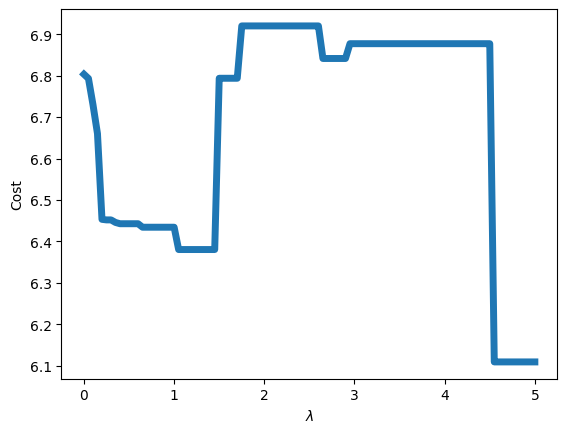

In [93]:
plt.plot(search_range, objective_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

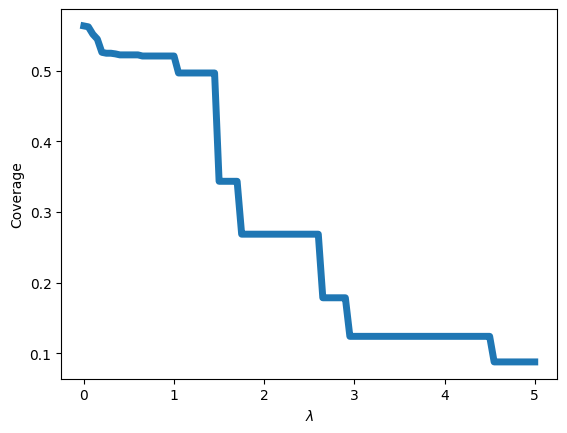

In [94]:
plt.plot(search_range, coverage_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

In [80]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.75,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,10,101),
    'full_search' : False,
    'cpu_count' : 1
}

In [81]:
forest.prune(**prune_params)
forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)

ValueError: Decision set has not been pruned. If prune() was called, this is likely because coverage requirements were not met.

In [82]:
forest_depth_imm.prune(**prune_params)
forest_depth_imm_prune_predictions = forest_depth_imm.pruned_predict(data, rule_labels = False)

In [83]:
svm_set.prune(**prune_params)
svm_set_prune_predictions = svm_set.pruned_predict(data, rule_labels = False)

ValueError: Decision set has not been pruned. If prune() was called, this is likely because coverage requirements were not met.